In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import seaborn as sns
import os
os.chdir("/content/drive/MyDrive/study/RStanBook/")

In [2]:
df = pd.read_table('data/data-aircon.txt', sep=',')
df.head()

,X,Y
0,-2.1,98.2
1,-1.9,109.3
2,-1.3,95.4
3,-1.4,93.5
4,-1.3,95.5


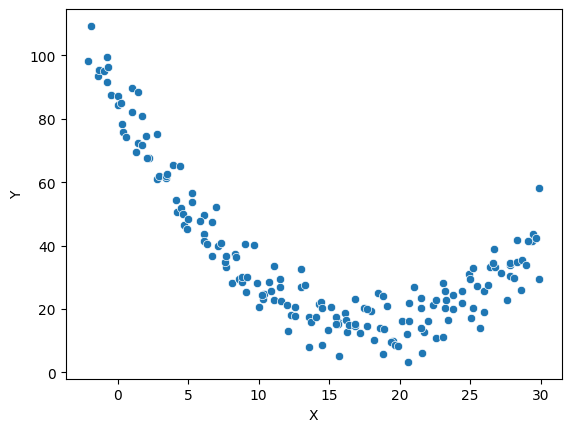

In [4]:
fig, ax = plt.subplots()
sns.scatterplot(x=df["X"], y=df["Y"], ax=ax)
plt.show()

In [14]:
# 20度前後に快適さを感じ、それを境にエアコン利用が増えると考える

model = pm.Model()

with model:
    x_data = pm.Data("x_data", df["X"], mutable=True)
    y_data = pm.Data("y_data", df["Y"], mutable=True)

    a = pm.Normal('a', mu=0, sigma=10.0)
    b = pm.Normal('b', mu=0, sigma=10.0)
    x0 = pm.Normal("x0", mu=20, sigma=10.0)
    sigma = pm.HalfNormal("sigma", sigma=10.0)

    mu = pm.Deterministic("mu", a + b*(x_data-x0)**2)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)

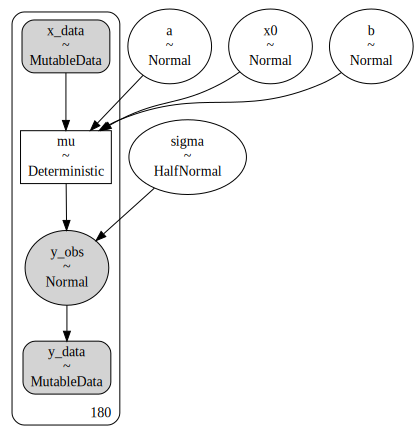

In [15]:
pm.model_to_graphviz(model)

In [16]:
with model:
    idata1 = pm.sample(draws=3000, tune=1000, chains=3, random_seed=42)

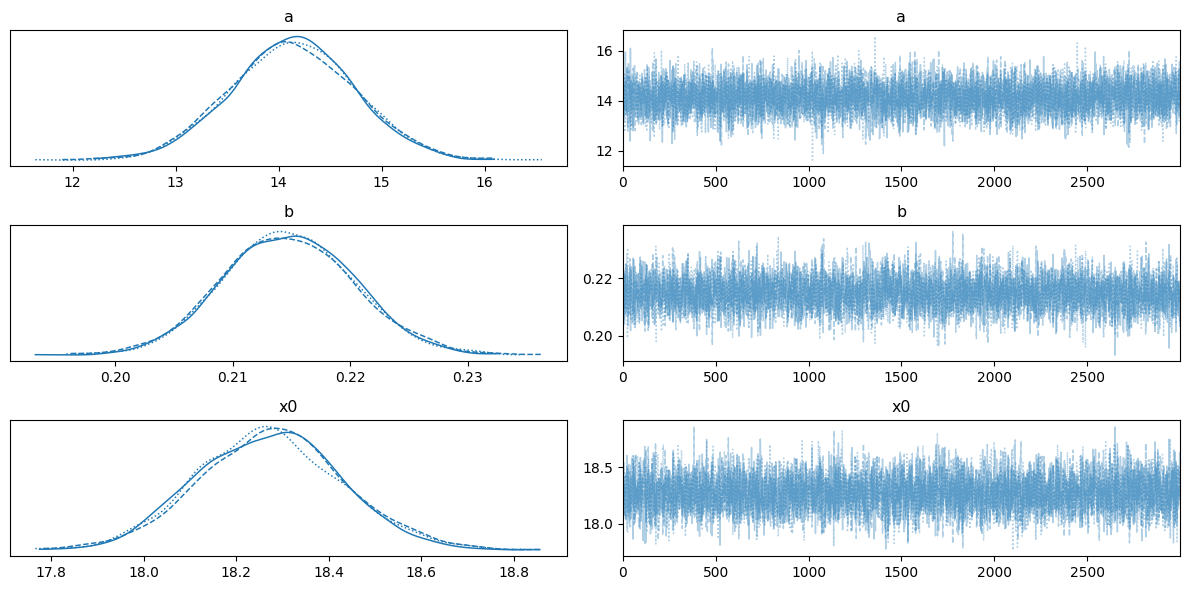

In [17]:
az.plot_trace(idata1, var_names=['a', 'b', "x0"])
plt.tight_layout();

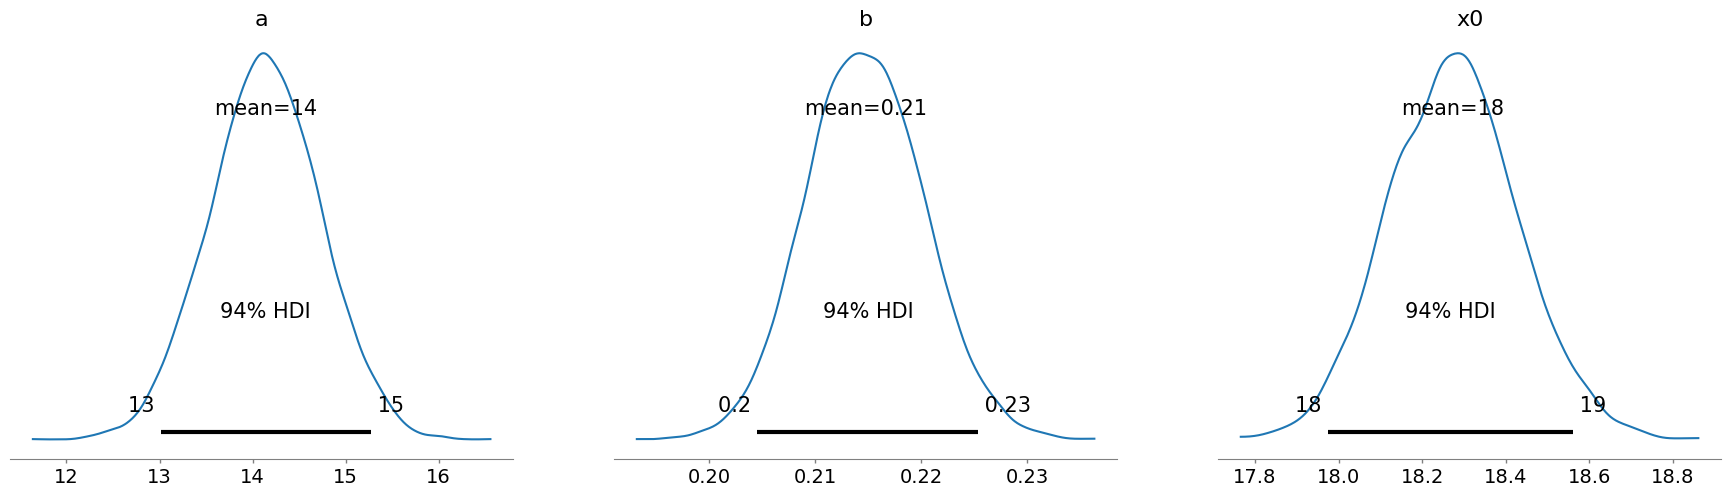

In [19]:
az.plot_posterior(idata1, var_names=['a', 'b', "x0"]);

In [20]:
az.summary(idata1, var_names=['a', 'b', "x0"])

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,14.136,0.599,13.013,15.271,0.007,0.005,6430.0,6209.0,1.0
b,0.215,0.006,0.205,0.225,0.000,0.000,4968.0,5050.0,1.0
x0,18.274,0.155,17.976,18.560,0.002,0.001,5555.0,5781.0,1.0


In [21]:
with model:
    pm.sample_posterior_predictive(idata1, extend_inferencedata=True, random_seed=42)

In [33]:
y_preds = idata1["posterior_predictive"]["y_obs"].to_numpy().reshape(-1, 180)
y_preds_50 = np.quantile(y_preds, [0.025, 0.975], axis=0)
y_preds_95 = np.quantile(y_preds, [0.25, 0.75], axis=0)

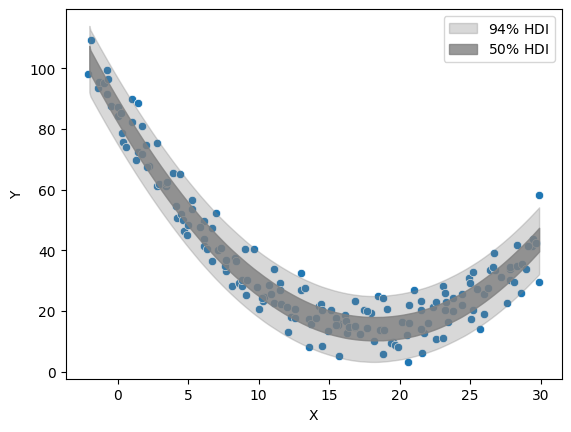

In [38]:
fig, ax = plt.subplots()
sns.scatterplot(x=df["X"], y=df['Y'], ax=ax)
# デフォルトが94%HDI
pm.plot_hdi(df['X'], idata1.posterior_predictive["y_obs"], ax=ax, fill_kwargs={'color': 'gray', 'alpha': 0.3, 'label': r'$94\%$ HDI'})
pm.plot_hdi(df['X'], idata1.posterior_predictive["y_obs"], hdi_prob=0.5, ax=ax, fill_kwargs={'color': 'gray', 'alpha': 0.8, 'label': r'$50\%$ HDI'})
plt.legend()
plt.show()

In [39]:
df2 = pd.read_table('data/data-salary.txt', sep=',')
df2.head()

,X,Y
0,24,472
1,24,403
2,26,454
3,32,575
4,33,546


In [75]:
model2 = pm.Model()
N = len(df2)

with model2:
    X_data = pm.Data("X_data", df2['X'], mutable=True)
    y_data = pm.Data("y_data", df2['Y'], mutable=True)

    a = pm.Normal('a', mu=0.0, sigma=100.0)
    b = pm.Normal('b', mu=0.0, sigma=100.0)
    # +-2.5くらいの年齢推定誤差アプリで年齢を推定したデータであるを記述する
    # 真の年齢X_true_muを平均、2.5を標準偏差に持つ正規分布から推定年齢が出てくると考える
    # sigmaに誤差を与えて天気予報データを作ることもできるかも
    X_true = pm.Normal("X_true", mu=40.0, sigma=20.0, shape=N)
    X_obs = pm.Normal("X_obs", mu=X_true, sigma=2.5, observed=X_data)

    # 真の年齢を使った線型結合の式で年収が決まっていると考える
    mu = pm.Deterministic("mu", a+b*X_true)
    sigma = pm.HalfNormal("sigma", sigma=100.0)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)

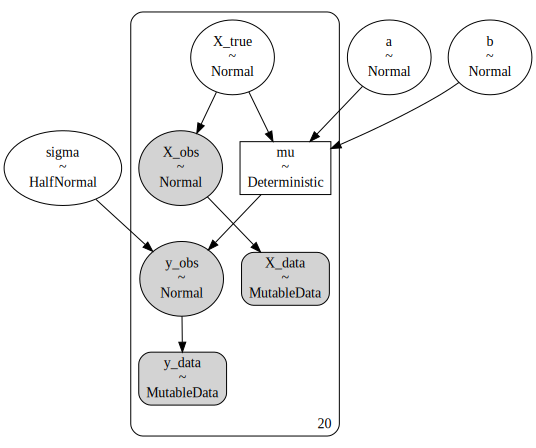

In [76]:
pm.model_to_graphviz(model2)

In [82]:
with model2:
    idata2 = pm.sample(draws=2000, tune=1000, chains=2, random_seed=42, target_accept=0.995)

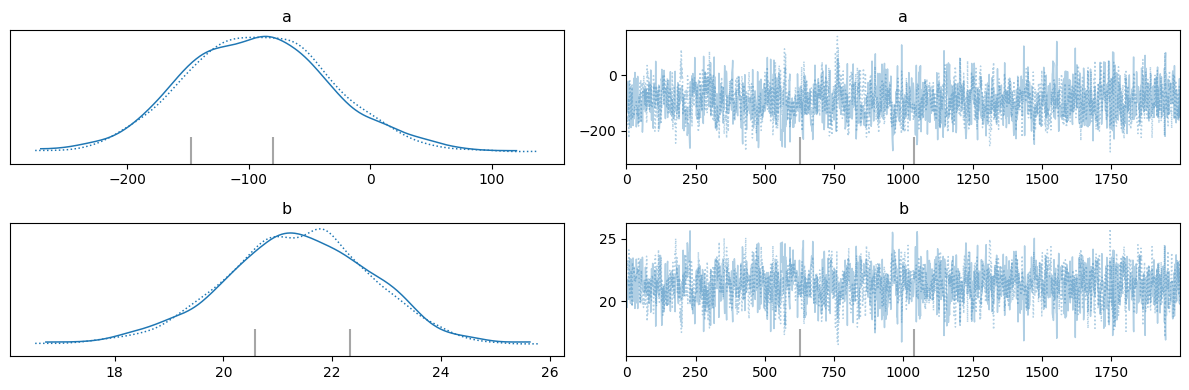

In [83]:
az.plot_trace(idata2, var_names=['a', 'b'])
plt.tight_layout();

In [84]:
az.summary(idata2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-92.303,59.836,-203.858,18.543,1.819,1.287,1079.0,1597.0,1.0
b,21.357,1.359,18.911,24.012,0.041,0.029,1101.0,1938.0,1.0
X_true[0],25.309,1.972,21.563,28.917,0.047,0.033,1808.0,2406.0,1.0
X_true[1],23.826,1.908,20.006,27.185,0.034,0.024,3203.0,2647.0,1.0
X_true[2],25.973,1.873,22.496,29.536,0.033,0.023,3203.0,2693.0,1.0
X_true[3],31.746,1.871,28.230,35.253,0.031,0.022,3764.0,2746.0,1.0
X_true[4],31.652,1.894,28.097,35.261,0.034,0.024,3239.0,2728.0,1.0
X_true[5],37.816,2.104,33.795,41.597,0.064,0.046,1041.0,1657.0,1.0
X_true[6],38.707,1.899,34.988,42.153,0.033,0.024,3287.0,2695.0,1.0
X_true[7],36.506,2.168,32.447,40.463,0.071,0.050,893.0,1578.0,1.0


In [19]:
df3 = pd.read_csv("data/data-protein.txt", sep=',')
df3['Y'] = df3['Y'].astype(str).str.replace('<', '').astype(float)
print(df3.shape)
df3

(6, 1)


,Y
0,25.0
1,32.3
2,25.0
3,28.3
4,30.8
5,35.2


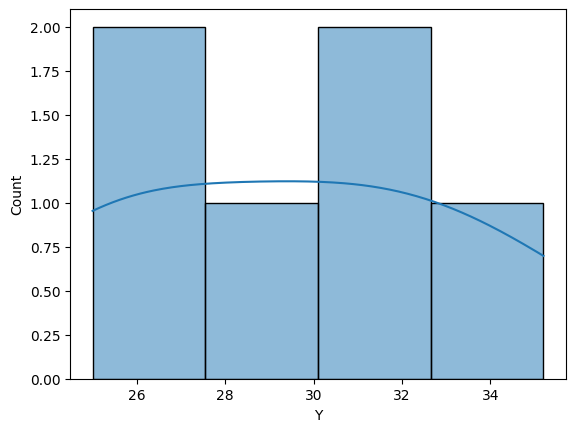

In [6]:
fig, ax = plt.subplots()
sns.histplot(df3['Y'], kde=True)
plt.show()

In [10]:
# https://www.pymc.io/projects/docs/en/latest/api/distributions/censored.html
model3 = pm.Model()

with model3:
    Y_data = pm.Data("Y_data", df3['Y'], mutable=True)

    mu = pm.Normal("mu", mu=0.0, sigma=100.0)
    sigma = pm.HalfNormal("sigma", sigma=100.0)

    normal_dist = pm.Normal.dist(mu=mu, sigma=sigma)
    y_censored = pm.Censored("y_censored", normal_dist, lower=25, upper=None, observed=Y_data)

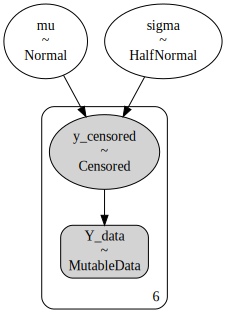

In [11]:
pm.model_to_graphviz(model3)

In [15]:
with model3:
    idata3 = pm.sample(draws=2000, tune=1000, chains=2, random_seed=42, target_accept=0.995)

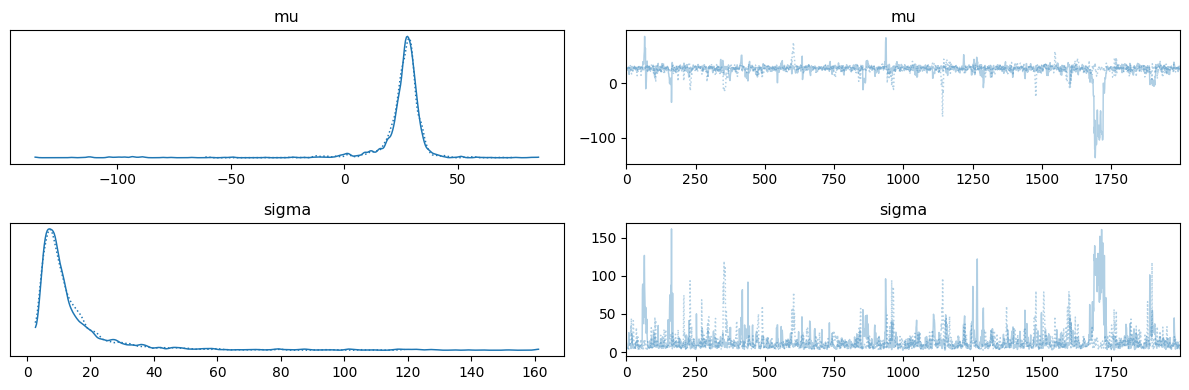

In [16]:
az.plot_trace(idata3, var_names=['mu', 'sigma'])
plt.tight_layout();

In [17]:
az.summary(idata3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,25.207,13.602,8.503,38.308,1.171,0.830,526.0,216.0,1.0
sigma,14.566,15.605,2.846,35.936,1.062,0.808,498.0,328.0,1.0


In [37]:
df4 = pd.read_csv("data/data-outlier.txt")
print(df4.shape)
df4.head()

(10, 2)


,X,Y
0,1,3.4
1,2,8.2
2,3,40.0
3,4,17.6
4,5,20.3


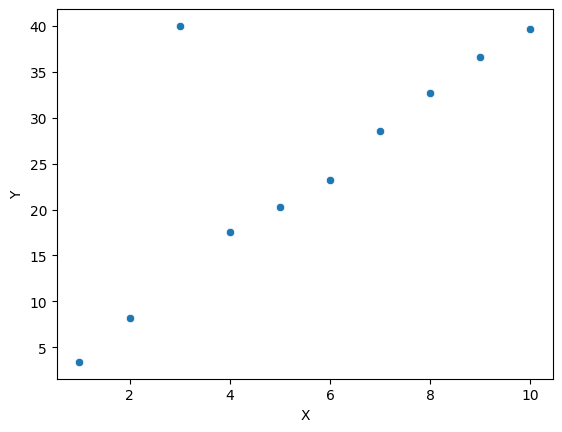

In [23]:
fig, ax = plt.subplots()
sns.scatterplot(x=df4['X'], y=df4['Y'], ax=ax)
plt.show()

In [27]:
# データが正規分布から生成されることを仮定した場合
model4 = pm.Model()
with model4:
    X_data = pm.Data("X_data", df4['X'])
    Y_data = pm.Data("Y_data", df4['Y'])
    a = pm.Normal("a", mu=0, sigma=100)
    b = pm.Normal("b", mu=0, sigma=100)
    sigma = pm.HalfNormal("sigma", sigma=100)
    mu = pm.Deterministic("mu", a+b*X_data)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y_data)

with model4:
    idata4 = pm.sample(draws=2000, tune=1000, chains=2, random_seed=42)

/usr/local/lib/python3.10/dist-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [29]:
with model4:
    pm.sample_posterior_predictive(idata4, extend_inferencedata=True, random_seed=42)

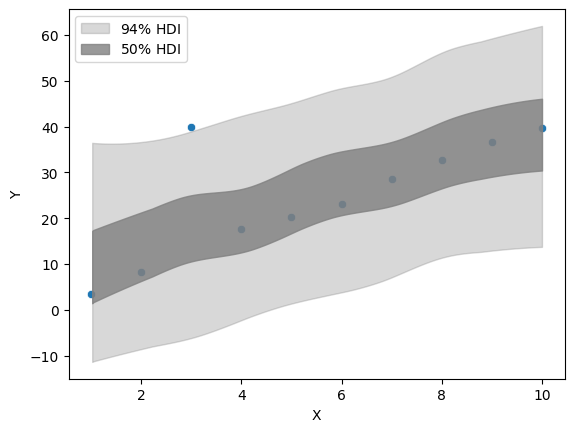

In [30]:
fig, ax = plt.subplots()
sns.scatterplot(x=df4["X"], y=df4['Y'], ax=ax)
# デフォルトが94%HDI
pm.plot_hdi(df4['X'], idata4.posterior_predictive["y_obs"], ax=ax, fill_kwargs={'color': 'gray', 'alpha': 0.3, 'label': r'$94\%$ HDI'})
pm.plot_hdi(df4['X'], idata4.posterior_predictive["y_obs"], hdi_prob=0.5, ax=ax, fill_kwargs={'color': 'gray', 'alpha': 0.8, 'label': r'$50\%$ HDI'})
plt.legend()
plt.show()

In [31]:
# データが正規分布から生成されることを仮定した場合
model4_2 = pm.Model()
with model4_2:
    X_data = pm.Data("X_data", df4['X'])
    Y_data = pm.Data("Y_data", df4['Y'])
    a = pm.Normal("a", mu=0, sigma=100)
    b = pm.Normal("b", mu=0, sigma=100)
    beta = pm.HalfNormal("beta", sigma=100)
    alpha = pm.Deterministic("alpha", a+b*X_data)
    # 裾の広い正規分布のようなコーシー分布を考えることで、外れ値もまあまあ出てくるものと考える
    y_obs = pm.Cauchy("y_obs", alpha=alpha, beta=beta, observed=Y_data)

with model4_2:
    idata4_2 = pm.sample(draws=2000, tune=1000, chains=2, random_seed=42)

/usr/local/lib/python3.10/dist-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [32]:
with model4_2:
    pm.sample_posterior_predictive(idata4_2, extend_inferencedata=True, random_seed=42)

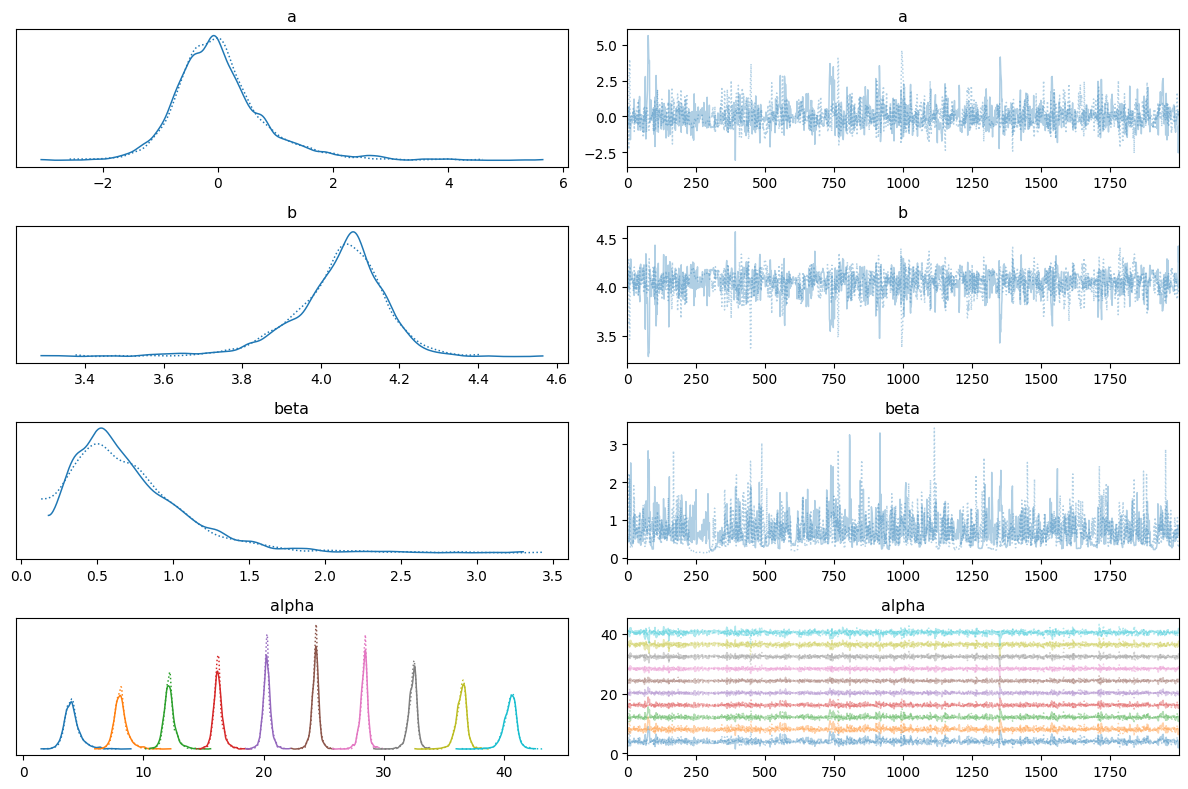

In [36]:
az.plot_trace(idata4_2, )
plt.tight_layout();

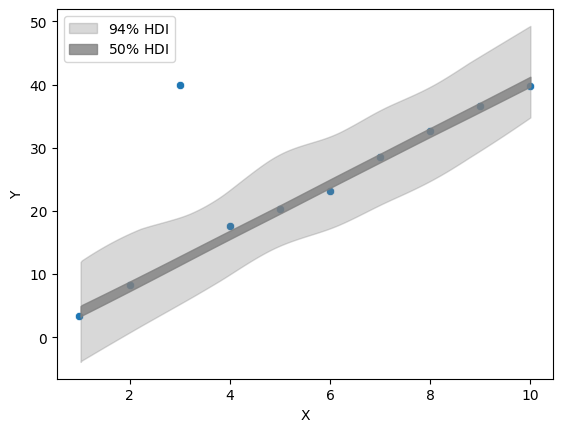

In [35]:
fig, ax = plt.subplots()
sns.scatterplot(x=df4["X"], y=df4['Y'], ax=ax)
# デフォルトが94%HDI
pm.plot_hdi(df4['X'], idata4_2.posterior_predictive["y_obs"], ax=ax, fill_kwargs={'color': 'gray', 'alpha': 0.3, 'label': r'$94\%$ HDI'})
pm.plot_hdi(df4['X'], idata4_2.posterior_predictive["y_obs"], hdi_prob=0.5, ax=ax, fill_kwargs={'color': 'gray', 'alpha': 0.8, 'label': r'$50\%$ HDI'})
plt.legend()
plt.show()